### University of Washington: Machine Learning and Statistics 

# Lecture 8: Generative Classification

Andrew Connolly and Mario Juric

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 9.1-9.4 
- [astroML website](https://www.astroml.org/index.html)

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and associated material are available from [github](https://github.com/uw-astro/astr-598a-spr24).

The jupyterhub with the software installed is available at [jupyterhub](https://jupyter.rttl.uw.edu/2024-spring-astr-598-a).

In [3]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm

In [4]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 150
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
cmap = cm.get_cmap('viridis')

## Dataset

AstroML gives us easy access to a dataset of photometric colors of SDSS standard stars and RR Lyrae stars confirmed by time series observations. Looking at the [documentation](https://www.astroml.org/modules/generated/astroML.datasets.fetch_rrlyrae_combined.html), we see that the four columns of X are the colors u-g, g-r, r-i, and i-z, and that y is 1 if the star is an RR Lyrae or a 0 if it is not. We have almost 100,000 stars to work with!

In [5]:
# fetch the data and print its dimensions
X, y = fetch_rrlyrae_combined()
features = ['u-g', 'g-r', 'r-i', 'i-z']
labels = ['non-variable', 'RR Lyrae']
print('X.shape', X.shape)
print('y.shape', y.shape)

X.shape (93141, 4)
y.shape (93141,)


In [6]:
def plot_rrlyrae(scatterfn=None, histfn=None):    
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(hspace=0, wspace=0)

    # loop through every possible pair of features
    for i in range(4):
        for j in range(4):
            # only make subplots in the lower diagonal
            if i <= j:
                ax = plt.subplot(4,4,i+j*4+1)
                # if this subplot is on the left side (but not the top), make a y label
                if i == 0 and j != 0:
                    ax.set_ylabel(features[j])
                # if this subplot is on the bottom, make an x label
                if j == 3:
                    ax.set_xlabel(features[i])
                # remove ticks on interior plots
                if i != 0:
                    ax.set_yticks([])
                if j != 3:
                    ax.set_xticks([])
                # scatter plots in off diagonals
                if i < j:
                    ax.scatter(X[y==0,i], X[y==0,j], s=1, marker='.', c=y[y==0], vmin=0, vmax=1, alpha=0.005)
                    ax.scatter(X[y==1,i], X[y==1,j], s=1, marker='.', c=y[y==1], vmin=0, vmax=1, alpha=0.25)
                    if scatterfn is not None:
                        scatterfn(ax, i, j)
                    ax.set_xlim(np.min(X[:,i]), np.max(X[:,i]))
                    ax.set_ylim(np.min(X[:,j]), np.max(X[:,j]))
                # normalized histograms on diagonals, with same colour map as scatter plots
                if i == j:
                    plt.hist([X[y == 0, i], X[y == 1, i]], density=True, histtype='stepfilled',\
                             label=labels, color=[cmap(0.), cmap(1.)], alpha=0.5)

                    if histfn is not None:
                        histfn(ax, i)

                    plt.yticks([]) # don't want counts in the y-axis
                    # add a legend
                    if i == 0:
                        plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', title='labels')
    plt.show()

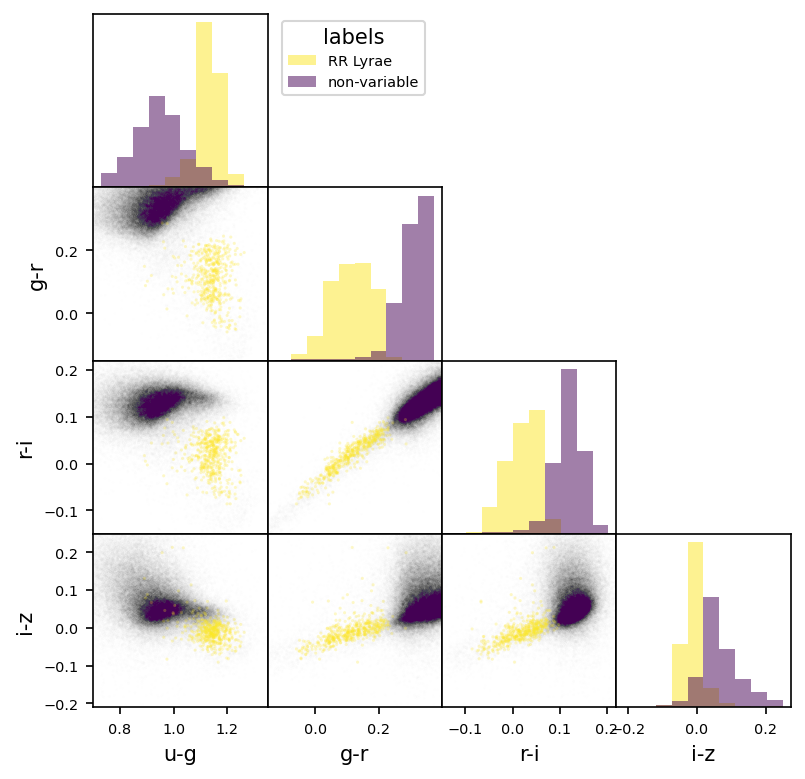

In [7]:
plot_rrlyrae()

Finally, let's split our data into training, validation, and test sets.

In [8]:
# split our data into training and validation sets
# setting random_state makes this split deterministic
(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)

## Generative Classification

In **generative classification**, we explicitly model the probability densities of points of each class $y_k$, $p(x | y_k)$. Then given a new data point $x'$, we can use Bayes's rule to find the posterior probability that this point belongs to any class $y_k$:

$$ p(y_k|x') = \frac{p(x'|y_k) p(y_k)}{\sum_k p(x'|y_k) p(y_k)}$$

which requires us to set priors that a point belongs to each class $p(y_k)$ - we can set these priors using the fraction of points belonging to each class. $p(y_k|x')$ is sometimes called the discriminant function, and is often returned by libraries like `scikit-learn`.

To use generative classification, we first need to choose and train a model of $p(x|y_k)$ for each class using a labeled training set.

### Gaussian Naive Bayes

In Gaussian Naive Bayes, we use a simple model for $p(x|y_k)$, independent Gaussians for each dimension:

$$p(x|y_k) = \prod_i \frac{1}{\sqrt{2 \pi \sigma_{k,i}^2}} \exp \left(-\frac{(x^i - \mu_{k,i})^2}{2 \sigma_{k,i}^2}\right)$$

In [9]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

Let's look at the Gaussians that are fit to the data:

In [10]:
def scatter_gnb(ax, i, j):
    for k in range(2): #for each class
        ell = mpl.patches.Ellipse(gnb.theta_[k, [i,j]], np.sqrt(gnb.var_[k,i]), np.sqrt(gnb.var_[k,j]),
                                                  0, ec='k', fill=False)
        ax.add_artist(ell)

def hist_gnb(ax, i):
    plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
    for k in range(2): # for each class
            dist = norm(loc=gnb.theta_[k,i], scale=np.sqrt(gnb.var_[k,i]))
            plt.plot(plotx, dist.pdf(plotx), color=cmap(float(k)))

/tmp/ipykernel_30557/431793058.py:3: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gnb.theta_[k, [i,j]], np.sqrt(gnb.var_[k,i]), np.sqrt(gnb.var_[k,j]),


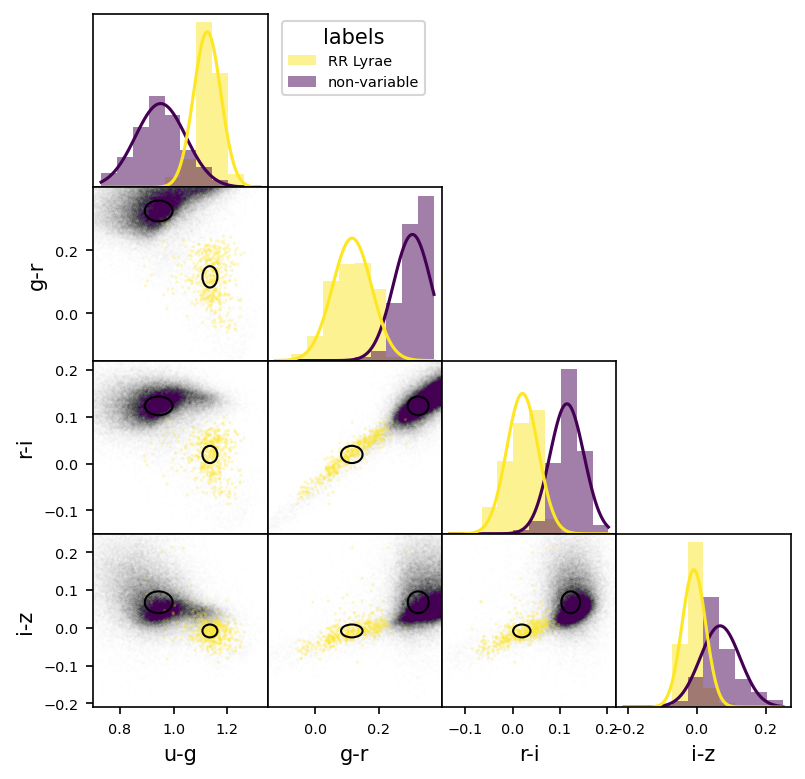

In [11]:
plot_rrlyrae(scatterfn=scatter_gnb, histfn=hist_gnb)

The Gaussian Naive Bayes classifier assumes that the distributions will be axis-aligned. It reproduces the marginal distributions, but not the covariances between features. Let's see how it does on the validation set. The classifier will classify each point with the class that maximizes $p(y_k|x)$.

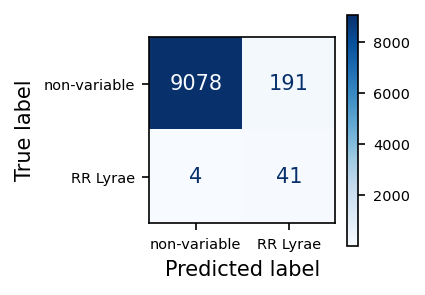

RR Lyrae Recall 0.911
RR Lyrae Precision 0.177


In [12]:
y_pred = gnb.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

$${\rm recall} = \frac{{\rm true\ positives}}{{\rm true\ positives} + {\rm false\ negatives}}$$
 
$${\rm precision} = \frac{{\rm true\ positives}}{{\rm true\ positives} + {\rm false\ positives}}$$

The Gaussian Naive Bayes has good recall, but low precision. Astronomers will often say **completeness** for recall, and **contamination** for 1 - precision.

### Linear Discriminant Analysis

In LDA, we model all classes as having Gaussian distributions with different means $\mu_k$ but the same covariance matrix $\Sigma$:

$$p(x|y_k) = \frac{1}{\sqrt{\det 2\pi \Sigma}} \exp\left( -\frac{1}{2} (x - \mu_k)^T \Sigma^{-1} (x - \mu_k)\right)$$

This has the advantage of making the decision boundary between two classes linear:
$$p(x|y_k) = p(x|y_l) \Rightarrow x^T \Sigma^{-1} (\mu_k - \mu_l) - \frac{1}{2} \left(\mu_k^T \Sigma^{-1} \mu_k - \mu_l^T \Sigma^{-1} \mu_l \right) + \log\left(\frac{p(y_k)}{p(y_l)}\right)$$

When there are $K$ classes, LDA can be used to do a linear dimensionality reduction to the $K-1$ dimensions (the linear discriminants) that best separate the classes. See the [scikit-learn User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction) for more details.

In [13]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [14]:
# convenience function to turn 2D covariance matrix into semi-major/minor axis and position angle of error ellipse
def covariance_to_vangle(covariance):
    # adapted from "GMM Covariances"
    # https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
    v, w = np.linalg.eigh(covariance)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    return v, angle

def scatter_lda(ax, i, j):
    idx = [i,j]
    rows = [[i, i], [j, j]]
    cols = [[i, j], [i, j]]
    
    v, angle = covariance_to_vangle(lda.covariance_)
    
    for k in range(2): # for each class
        ell = mpl.patches.Ellipse(lda.means_[k, idx], v[0], v[1],
                                  180 + angle, ec='k', fill=False)
        ax.add_artist(ell)


def hist_lda(ax, i):
    plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
    for k in range(2): # for each class
            dist = norm(loc=lda.means_[k,i], scale=np.sqrt(lda.covariance_[i,i]))
            plt.plot(plotx, dist.pdf(plotx), color=cmap(float(k)))

/tmp/ipykernel_30557/3520350594.py:20: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(lda.means_[k, idx], v[0], v[1],


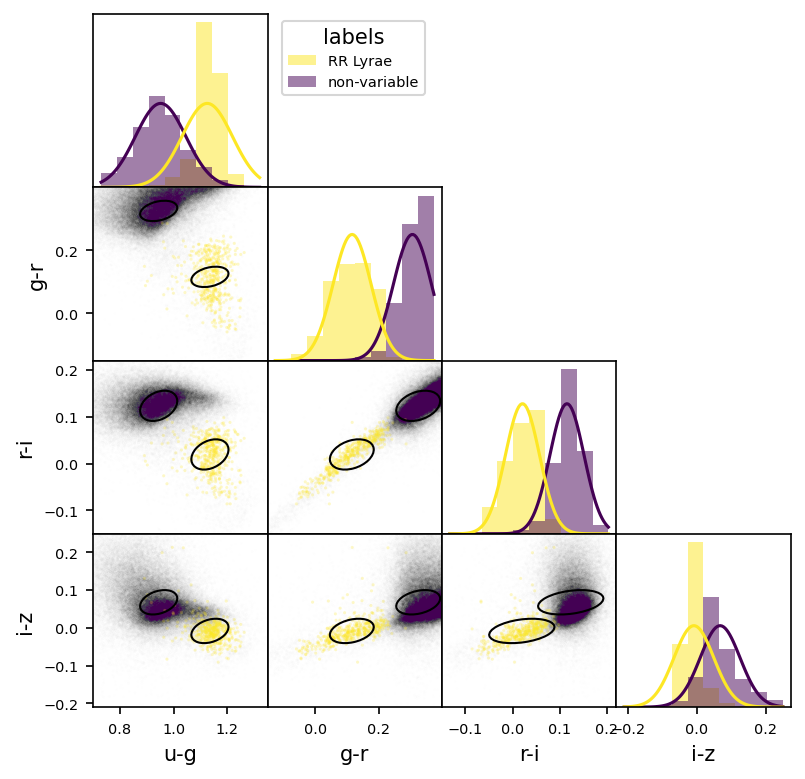

In [15]:
plot_rrlyrae(scatterfn=scatter_lda, histfn=hist_lda)

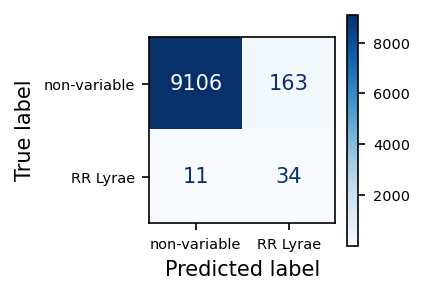

RR Lyrae Recall 0.756
RR Lyrae Precision 0.173


In [16]:
y_pred = lda.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

LDA has worse recall and precision than Naive Gaussian Bayes, but it only uses one linear discriminant, which is a linear combination of the four features.

### Gaussian Mixture Model Bayes

In GMM Bayes, we model each class as having a Gaussian Mixture Model distribution with $N$ components:
$$p(x|y_k) = \sum_{l=1}^N \frac{w_{k,l}}{\sqrt{\det 2\pi \Sigma_{k,l}}} \exp\left( -\frac{1}{2} (x - \mu_{k,l})^T \Sigma_{k,l}^{-1} (x - \mu_{k,l})\right)$$
with $\sum_{l=1}^N w_{k,l} = 1$ to make sure the mixture model is normalized.

In the case of $N=1$, this is Gaussian Naive Bayes except the covariance matrix can have off-diagonal elements, and is also called Quadratic Discriminant Analysis because the decision boundary is quadratic in $x$.

In [17]:
# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

GMMBayes(n_components=array([4]))

In [18]:
def scatter_gmmb(ax, i, j):
    idx = [i,j]
    rows = [[i, i], [j, j]]
    cols = [[i, j], [i, j]]
        
    for k in range(2): # for each class
        for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
            covariance = gmmb.gmms_[k].covariances_[l][rows, cols]
            
            v, angle = covariance_to_vangle(covariance)
            
            ell = mpl.patches.Ellipse(gmmb.gmms_[k].means_[l, idx], v[0], v[1],
                                      180 + angle, ec=cmap(float(k)), fill=False)
            ell.set_alpha(gmmb.gmms_[k].weights_[l])
            ax.add_artist(ell)

def hist_gmmb(ax, i):
    plotx = np.linspace(np.min(X[:,i]), np.max(X[:,i]), 100)
    for k in range(2): # for each class
        for l in range(gmmb.gmms_[k].n_components): # for each Gaussian
            dist = norm(loc=gmmb.gmms_[k].means_[l,i], scale=np.sqrt(gmmb.gmms_[k].covariances_[l][i,i]))
            plt.plot(plotx, dist.pdf(plotx), color=cmap(float(k)), alpha=gmmb.gmms_[k].weights_[l])

/tmp/ipykernel_30557/3718802128.py:12: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmmb.gmms_[k].means_[l, idx], v[0], v[1],


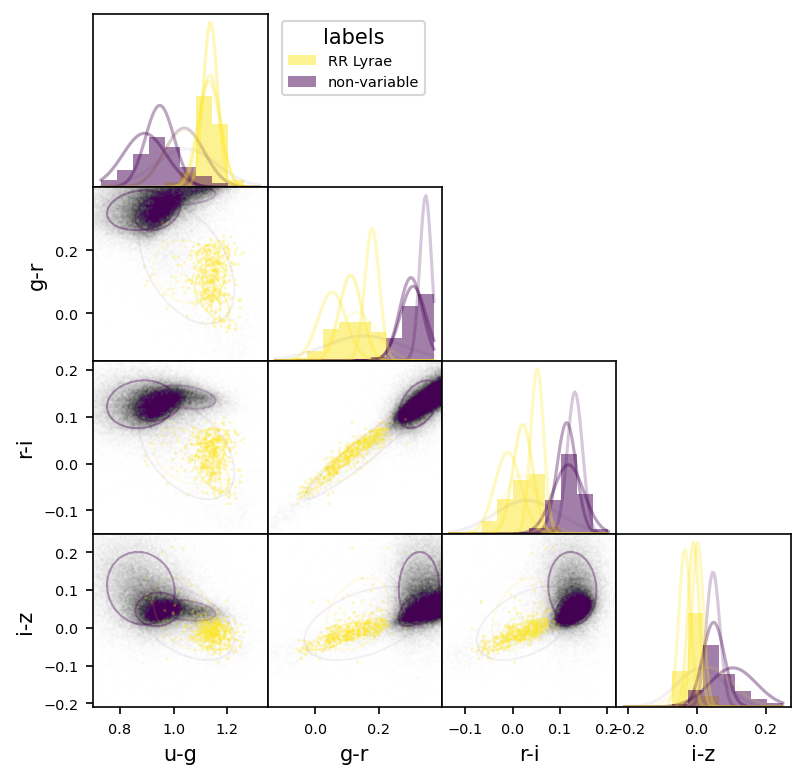

In [19]:
plot_rrlyrae(scatterfn=scatter_gmmb, histfn=hist_gmmb)

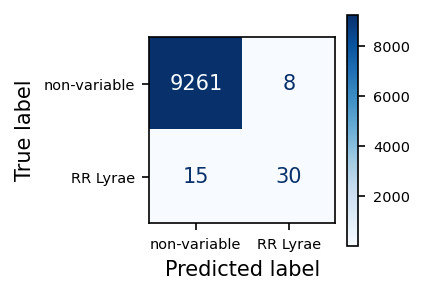

RR Lyrae Recall 0.667
RR Lyrae Precision 0.789


In [20]:
y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

### __Exercise__ What is the best number of components
- Find the best number of components $N$ for Gaussian Mixture Model Bayes by evaluating precision on the validation set.

## K-Nearest-Neighbor Classification
So far, we have modeled $p(x | y_k)$ with explicit distributions and used density estimation to find the best fit parameters for those distributions. We can take a non-parametric approach by looking at a small neighborhood around a point $x'$:

$$ p(x' | y_k) p(y_k) = p(x', y_k) \approx \frac{{\rm number\ of\ training\ points\ of\ class\ }k{\rm \ in\ neighborhood}}{{\rm volume\ of\ neighborhood} \times {\rm number\ of\ training\ points}}$$

Then the discriminant function is:

$$ p(y_k | x') \approx \frac{{\rm number\ of\ training\ points\ of\ class\ }k{\rm \ in\ neighborhood}}{{\rm total\ number\ of\ training\ points\ in\ neighborhood}} $$

How do we choose the neighborhood size? We want it to be bigger where the data are sparser and smaller where the data are denser, so choosing the neighborhood containing the $K$ nearest neighbors is a natural choice. This KNN classifier essentially finds the $K$ nearest neighbors to $x'$ and uses their labels as votes to decide how $x'$ should be classified. The definition of distance is important, so if the features have different units, scaling by the variance or range is often useful.

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

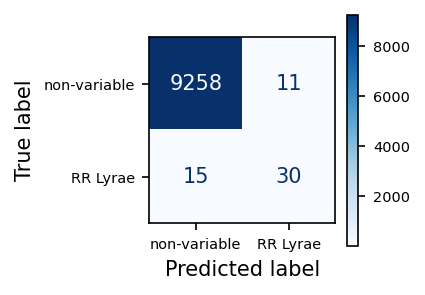

RR Lyrae Recall 0.667
RR Lyrae Precision 0.732


In [22]:
y_pred = knn.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

### Exercise
KNN is useful because it doesn't assume anything about the functional form of the probability distributions $p(x|y_k)$. The votes of each data point can be weighted by how close they are to $x'$ - this modification is akin to estimating $p(x'|y_k)$ by a kernel density estimate. Find the best number of nearest neighbors for KNN by evaluating precision on the validation set. Which method, KNN or GMMB, has the best precision on the test set?

## Precision-Recall Curve

We are currently using
$$P(y_k | x) \geq 0.5$$
as the decision boundary, but we can trade off between precision and recall by changing this boundary. Plotting the precision and recall as a function of the threshold gives us the precision-recall curve. A perfect classifier would have precision = 1 for all recall < 1, and recall = 1 for all precision < 1. A classifier that guesses has constant precision, equal to the fraction of positives in the data set. We can even compare different classifiers on this plot.

In [23]:
def label_point(x, y, text, **kwargs):
    plt.scatter(x, y, c='k')
    plt.text(x, y, ' '+text, **kwargs)

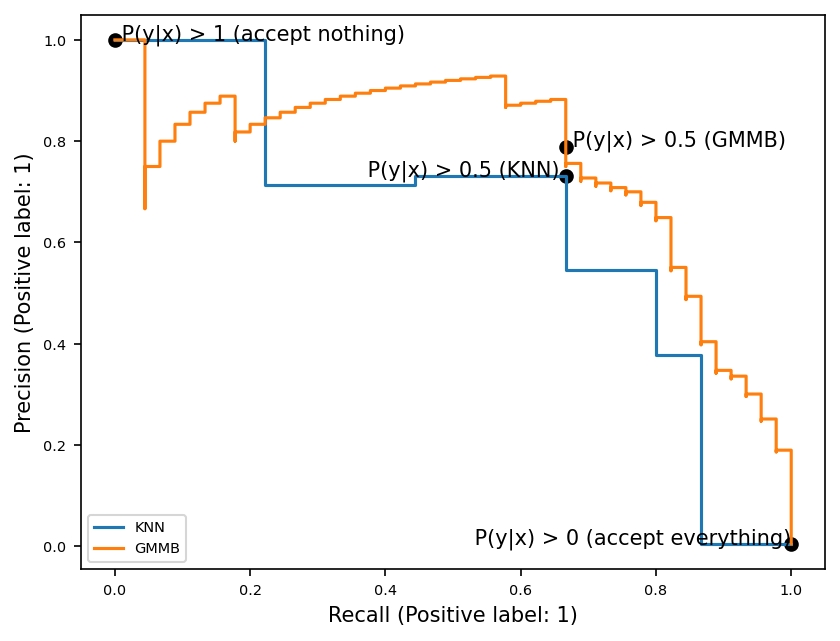

In [24]:
# log probabilities of being RR Lyrae
knn_log_proba = knn.predict_proba(X_valid)[:, 1]
gmmb_log_proba = gmmb.predict_proba(X_valid)[:, 1]

fig = plt.figure()
ax = fig.add_subplot()

PrecisionRecallDisplay.from_predictions(y_valid, knn_log_proba, label='KNN', ax=ax)
PrecisionRecallDisplay.from_predictions(y_valid, gmmb_log_proba, label='GMMB', ax=ax)

y_pred_gmmb = gmmb.predict(X_valid)
y_pred_knn = knn.predict(X_valid)
label_point(0, 1, 'P(y|x) > 1 (accept nothing)')
label_point(recall_score(y_valid, y_pred_knn), precision_score(y_valid, y_pred_knn), 'P(y|x) > 0.5 (KNN) ', ha='right')
label_point(recall_score(y_valid, y_pred_gmmb), precision_score(y_valid, y_pred_gmmb), 'P(y|x) > 0.5 (GMMB)',)
label_point(1, np.mean(y_valid), 'P(y|x) > 0 (accept everything)', ha='right')
plt.show()

A related curve is the [Receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which uses
$${\rm false\ positive\ rate} = \frac{{\rm false\ positives}}{{\rm false\ positives} + {\rm true\ negatives}}$$
$${\rm true\ positive\ rate} = {\rm recall}$$
A perfect classifier will have true positive rate = 1 for all false positive rates > 0, and false positive rate = 0 for all true positive rates < 1; while a classifier that guesses at random will yield a diagonal line. The area under the curve (AUC) is often used as a metric in and of itself. The false positive rate (and thus the ROC curve) is less useful for our data set, where the negatives drastically outnumber the positives.

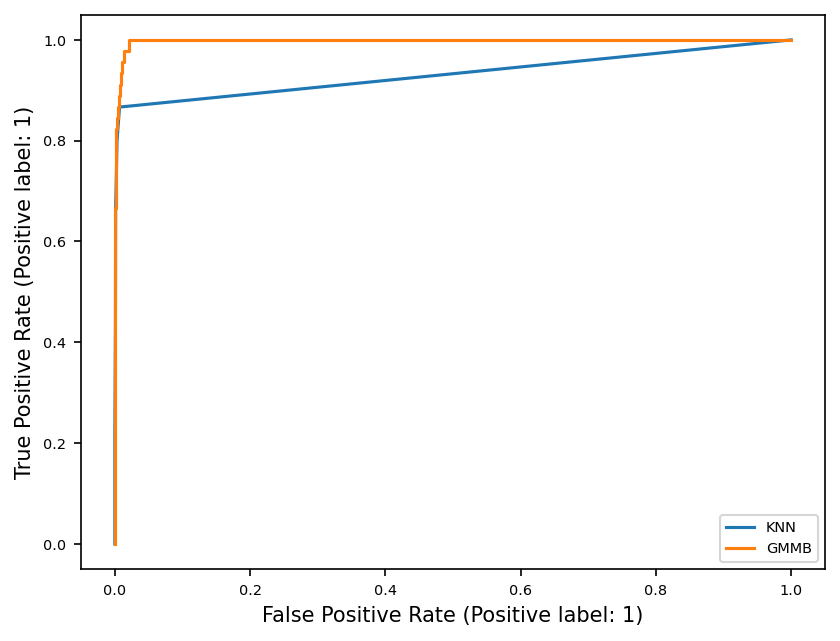

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

RocCurveDisplay.from_predictions(y_valid, knn_log_proba, label='KNN', ax=ax)
RocCurveDisplay.from_predictions(y_valid, gmmb_log_proba, label='GMMB', ax=ax)

plt.show()

### Exercise: Perform a star galaxy separation classification
- From the imaging data set with a range of different parameters select parameters that might separate stars from galaxies
- use one of the classifiers to separate stars and galaxies and plot the results
- evaluate its recall and precision

In [27]:
from astroML.datasets import fetch_imaging_sample
def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()

    objtype = data['type']

    stars = data[objtype == 6][:Nstars]
    
    galaxies = data[objtype == 3][:Ngals]

    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])

data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)
print(data.dtype.names)

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')
